In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
from scipy.ndimage import distance_transform_edt
from scipy.ndimage import zoom
from rasterio.warp import reproject, Resampling
from scipy.spatial import cKDTree
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import f1_score, precision_score, recall_score,balanced_accuracy_score, matthews_corrcoef, make_scorer
from xgboost import XGBClassifier, plot_importance 
import seaborn as sns
import matplotlib.colors as mcolors

In [2]:
paths = {
'fault': r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\fault_distance_raster.tif",
'litho': r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\Litho_Gold.tif",
'au': r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\Au_ppb.tif",
'intrusive': r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\Intrusive_Gold.tif",
'tmi': r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\Resampled_TMI.tif",
'geomorpho' : r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\Geomorphological_Classification.tif", 
'Kaolin' : r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\kaolin_Mosaic_Processed_classified.tif",
'AiOH' : r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\AiOH_Mosaic_Processed_classified.tif",
'FeOH' : r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\feoh_Mosaic_Processed_classified.tif",
'Ferric Oxide' : r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\ferricoxide_Mosaic_Processed_classified.tif",
'Ferric Oxide Comp.' : r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\ferricoxide_comp_Mosaic_Processed_classified.tif",
'Ferrous Iron' : r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\ferrousiron_Mosaic_Processed_classified.tif",
'Quartz' : r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\Quartz_Mosaic_Processed_classified.tif",
'Silica' : r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\Silica_Mosaic_Processed_classified.tif",
}

In [3]:
target_dir = r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\Target_Map_Binary_Gold.tif"

In [4]:
# Load and flatten all rasters
features = {}
for key, path in paths.items():
    with rasterio.open(path) as src:
        data = src.read(1)
        features[key] = data.flatten()
        profile = src.profile  # save for later use

# Combine into a DataFrame
df = pd.DataFrame(features)

In [5]:
df

,fault,litho,au,intrusive,tmi,geomorpho,Kaolin,AiOH,FeOH,Ferric Oxide,Ferric Oxide Comp.,Ferrous Iron,Quartz,Silica
0,1.000000,0.0,0.000000,1.0,82.151344,0.0,4,3,4,0,3,1,0,0
1,1.000000,0.0,0.000000,1.0,79.414116,0.0,4,3,3,0,3,4,0,0
2,1.000000,0.0,0.000000,1.0,78.398872,0.0,4,4,4,0,4,2,0,0
3,101.000000,0.0,0.000000,1.0,78.159088,0.0,2,4,1,0,4,4,0,0
4,101.000000,0.0,0.000000,1.0,81.135567,0.0,3,4,2,0,4,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4181632,54747.140625,0.0,1.251632,0.0,0.000000,0.0,0,0,0,0,0,0,0,0
4181633,54844.503906,0.0,1.251626,0.0,0.000000,0.0,0,0,0,0,0,0,0,0
4181634,54941.878906,0.0,1.251620,0.0,0.000000,0.0,0,0,0,0,0,0,0,0
4181635,55039.257812,0.0,1.251615,0.0,0.000000,0.0,0,0,0,0,0,0,0,0


In [6]:
with rasterio.open(target_dir) as src:
    y = src.read(1).flatten()

df['target'] = y

# Drop NaNs (mask where no values in any predictor or target)
df = df.dropna()

In [7]:
df

,fault,litho,au,intrusive,tmi,geomorpho,Kaolin,AiOH,FeOH,Ferric Oxide,Ferric Oxide Comp.,Ferrous Iron,Quartz,Silica,target
0,1.000000,0.0,0.000000,1.0,82.151344,0.0,4,3,4,0,3,1,0,0,0.0
1,1.000000,0.0,0.000000,1.0,79.414116,0.0,4,3,3,0,3,4,0,0,0.0
2,1.000000,0.0,0.000000,1.0,78.398872,0.0,4,4,4,0,4,2,0,0,0.0
3,101.000000,0.0,0.000000,1.0,78.159088,0.0,2,4,1,0,4,4,0,0,0.0
4,101.000000,0.0,0.000000,1.0,81.135567,0.0,3,4,2,0,4,4,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4181632,54747.140625,0.0,1.251632,0.0,0.000000,0.0,0,0,0,0,0,0,0,0,0.0
4181633,54844.503906,0.0,1.251626,0.0,0.000000,0.0,0,0,0,0,0,0,0,0,0.0
4181634,54941.878906,0.0,1.251620,0.0,0.000000,0.0,0,0,0,0,0,0,0,0,0.0
4181635,55039.257812,0.0,1.251615,0.0,0.000000,0.0,0,0,0,0,0,0,0,0,0.0


In [8]:
# Separate gold and background
df_gold = df[df['target'] == 1]
df_bg = df[df['target'] == 0]

print(f"Gold samples: {len(df_gold)}")
print(f"Background samples: {len(df_bg)}")

Gold samples: 48
Background samples: 4181589


In [12]:
print(df[df['target'] == 1]['geomorpho'].value_counts())
print(df[df['target'] == 1]['litho'].value_counts())
print(df[df['target'] == 1]['Kaolin'].value_counts())
print(df[df['target'] == 1]['AiOH'].value_counts())
print(df[df['target'] == 1]['FeOH'].value_counts())
print(df[df['target'] == 1]['Ferric Oxide'].value_counts())
print(df[df['target'] == 1]['Ferric Oxide Comp.'].value_counts())
print(df[df['target'] == 1]['Ferrous Iron'].value_counts())
print(df[df['target'] == 1]['Quartz'].value_counts())
print(df[df['target'] == 1]['Silica'].value_counts())

geomorpho
2.0    32
1.0    16
Name: count, dtype: int64
litho
1.0    24
2.0    17
3.0     5
0.0     1
5.0     1
Name: count, dtype: int64
Kaolin
4    22
3    11
2     6
0     5
1     4
Name: count, dtype: int64
AiOH
2    19
1    13
3     7
4     5
0     4
Name: count, dtype: int64
FeOH
4    18
3    13
2     8
1     5
0     4
Name: count, dtype: int64
Ferric Oxide
1    14
0    12
4     8
3     8
2     6
Name: count, dtype: int64
Ferric Oxide Comp.
2    19
1    13
3     7
4     5
0     4
Name: count, dtype: int64
Ferrous Iron
4    14
1    12
3    10
2     9
0     3
Name: count, dtype: int64
Quartz
4    22
3    12
1     8
2     5
0     1
Name: count, dtype: int64
Silica
0    15
2    12
1    11
4     7
3     3
Name: count, dtype: int64


###### Here, with 45 known gold samples, 12 samples are being classified in geomorpho code:1 
###### Initial case: With only 45 gold points, unless those gold pixels are evenly spread across geomorpho classes, the model can't generalize a trend

###### In short, the model concludes: "Whenever there’s gold, it’s basically always in geomorpho = 1. I don’t need to split further on this feature"

###### Here, we dropped the 'geomorpho' feature, although we can use it for masking background as an alternate method too. 

##### Set sampling ratio (e.g., 6:1 background to gold)

In [20]:
ratio = 10
bg_sample = df_bg.sample(n=ratio * len(df_gold), random_state=42)

In [64]:
# Combine for balanced dataset
df_bal = pd.concat([df_gold, bg_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# Define your features
predictor_cols = ['fault', 'litho', 'au', 'intrusive', 'tmi', 'geomorpho', 'Kaolin',
       'AiOH', 'FeOH', 'Ferric Oxide', 'Ferric Oxide Comp.', 'Ferrous Iron',
       'Quartz', 'Silica']
X = df_bal[predictor_cols]
y = df_bal['target']


##### Defining features

In [67]:
lithopredictor_cols = ['fault', 'litho', 'au', 'intrusive', 'tmi', 'geomorpho', 'Kaolin',
       'AiOH', 'FeOH', 'Ferric Oxide', 'Ferric Oxide Comp.', 'Ferrous Iron',
       'Quartz', 'Silica']   # 
X = df_bal[lithopredictor_cols]
y = df_bal['target']

In [69]:
X.shape, y.shape

((495, 14), (495,))

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [111]:
model = XGBClassifier(n_estimators=1000, max_depth=6, learning_rate=0.05, random_state=42)

In [113]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [114]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
threshold = 0.2   # Use diff 0.3, 0.4 etc
y_pred_custom = (y_prob >= threshold).astype(int)     

In [115]:
print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

AUC: 0.9641975308641976
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97        90
         1.0       0.80      0.44      0.57         9

    accuracy                           0.94        99
   macro avg       0.87      0.72      0.77        99
weighted avg       0.93      0.94      0.93        99

Confusion Matrix:
 [[89  1]
 [ 5  4]]


In [116]:
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

Precision: 0.8000
Recall: 0.4444
F1 Score: 0.5714
Balanced Accuracy: 0.7167
Matthews Correlation Coefficient (MCC): 0.5689


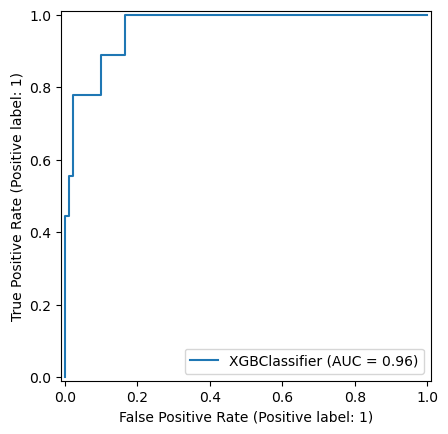

In [121]:
# ROC Curve
RocCurveDisplay.from_estimator(model, X_test, y_test)

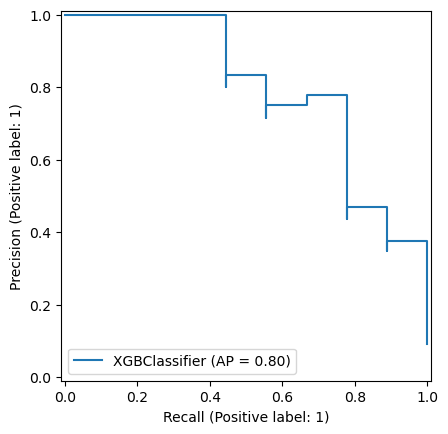

In [122]:
# PR Curve
PrecisionRecallDisplay.from_estimator(model, X_test, y_test)

In [124]:
model.feature_importances_

array([0.04062782, 0.43290266, 0.12189517, 0.        , 0.09586266,
       0.02694635, 0.01661064, 0.01778275, 0.03990091, 0.03605578,
       0.        , 0.04130723, 0.05712396, 0.07298404], dtype=float32)

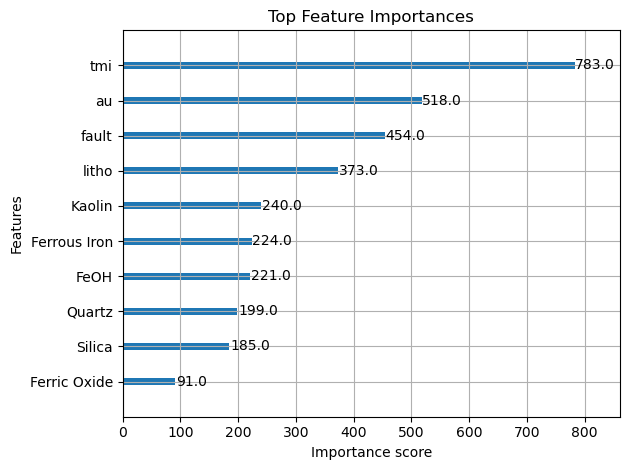

In [127]:
plot_importance(model, max_num_features=10)
plt.title("Top Feature Importances")
plt.tight_layout()
plt.show()

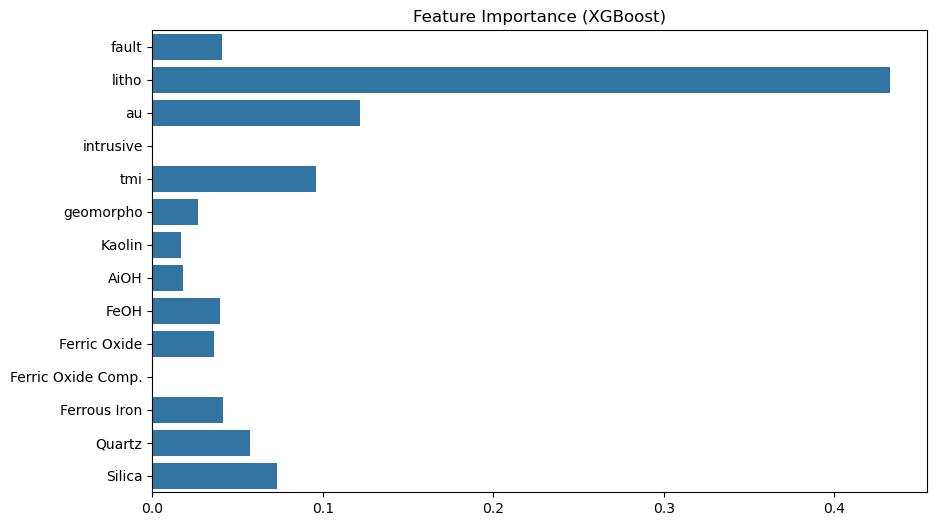

In [128]:
plt.figure(figsize=(10, 6))
sns.barplot(x=model.feature_importances_, y=predictor_cols)
plt.title("Feature Importance (XGBoost)")
plt.show()

In [129]:
X_full = df[predictor_cols]
y_pred_full = model.predict_proba(X_full)[:, 1]

In [130]:
prospectivity = np.full((profile['height'] * profile['width']), np.nan)
prospectivity[df.index] = y_pred_full
prospectivity = prospectivity.reshape((profile['height'], profile['width']))

In [132]:
prospectivity_masked = np.ma.masked_invalid(prospectivity)

In [134]:
p90 = np.nanpercentile(prospectivity, 90)

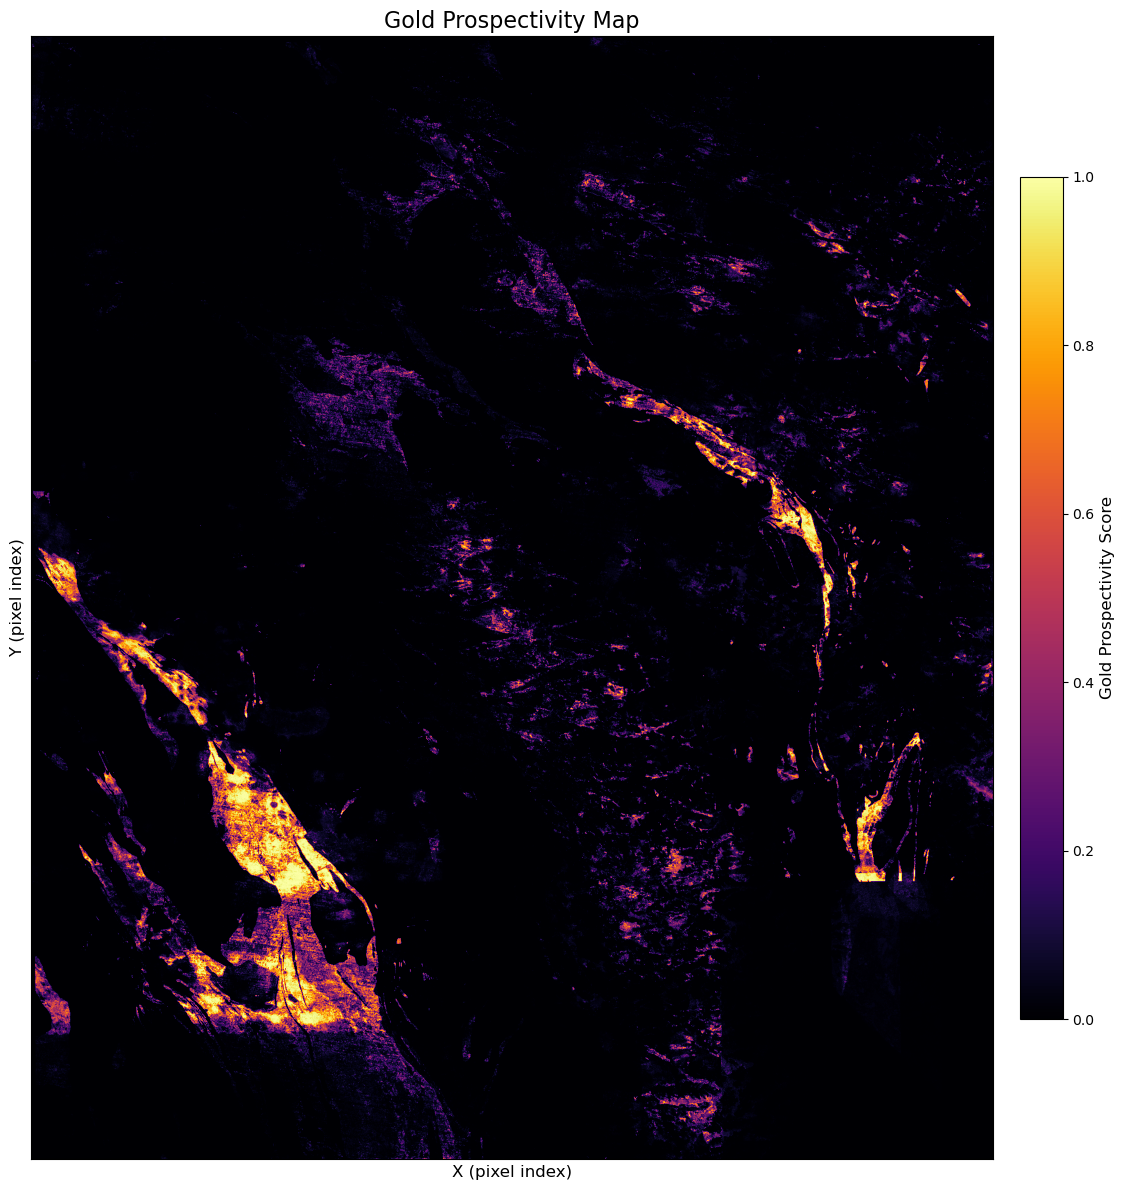

In [135]:
fig, ax = plt.subplots(figsize=(14, 12))
cmap = plt.cm.inferno
norm = mcolors.Normalize(vmin=0, vmax=1)

cax = ax.imshow(prospectivity_masked, cmap=cmap, norm=norm, origin='upper')
cbar = fig.colorbar(cax, ax=ax, shrink=0.75, orientation='vertical', pad=0.02)
cbar.set_label('Gold Prospectivity Score', fontsize=12)

#contour = ax.contour(prospectivity, levels=[p90], colors='cyan', linewidths=0.50)
#ax.clabel(contour, fmt={p90: 'P90'}, inline=False, fontsize=10)

ax.set_title("Gold Prospectivity Map", fontsize=16)
ax.set_xlabel("X (pixel index)", fontsize=12)
ax.set_ylabel("Y (pixel index)", fontsize=12)

#ax.text(0.01, 0.02, f"Threshold ≥ P90 = {p90:.2f}", transform=ax.transAxes,fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.tight_layout()
plt.savefig(r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Gold_Prospectivity\Gold Prospectivity Map (with geomorpho & Spectral Indices) with P90 Contour.png",dpi=400)
plt.show()

### Implementing Randomized Search for parameter optimization

In [ ]:
# define the model
xgb = XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid
param_dist = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'max_depth': [4, 6, 10, 15, 30],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'scale_pos_weight': [50, 100, 200, 500, int(len(y_train[y_train==0])/len(y_train[y_train==1]))]
}

# Define F1 score for imbalanced classification
scorer = make_scorer(f1_score, pos_label=1)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    scoring=scorer,
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

# Print best parameters
print("Best parameters found: ", random_search.best_params_)
